### load libraries

In [59]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### import the data we gathered from MSD Taste Profiles and Spotify Web API

In [2]:
msd_spot_df = pd.read_csv('taste_profiles_spotify.csv', index_col=0, header=0, dtype={'userID': str, 'songID': str, 
    'playcount': int, 'trackID': str, 'artist': str, 'title': str, 'trackID_spot': str, 'artistID_spot': str,
    'artistGenres': str, 'artistPop': int, 'trackPop': int, 'trackAcoustic': float, 'trackDanceable': float,
    'trackDurMS': int, 'trackEnergy': float, 'trackInstrum': float, 'trackKey': int, 'trackLoud': float, 'trackMode': int,
    'trackSpeech': float, 'trackTempo': float, 'trackVal': float, 'albumYear': int})

msd_spot_df

,userID,songID,playcount,trackID,artist,title,trackID_spot,artistID_spot,artistGenres,artistPop,...,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal,albumYear
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,72PoJMDfdaw9gGECgA9kTZ,0IecGJbdBeYSOVtSPRehh5,"classic soul, funk, psychedelic soul, quiet st...",53,...,156200,0.830,0.011200,9,-3.995,0,0.0283,102.800,0.909,1974
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,5hVqZ5hnvQGT4LOpUVuJUa,3h8OjAdgYXVRoMZ8jFd6Uw,"flamenco, flamenco guitar, rumba",55,...,360426,0.654,0.874000,4,-12.673,0,0.0349,102.814,0.924,1997
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,4HWqzvmeiaddzCDkSQcNxf,38euc5ce2q2MMzaoJcPstz,alternative country,44,...,196333,0.692,0.000008,1,-6.880,1,0.0266,100.614,0.523,2002
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,5GCB9mqJzKN4kDKvmqQ03X,4ssUf5gLb1GBLxi1BhPrVt,"cantautor, latin afrobeat, latin alternative, ...",68,...,164946,0.423,0.001160,7,-9.239,1,0.0302,78.005,0.507,2006
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,0j2T0R9dR9qdJYsB7ciXhf,5K4W6rqBFWDnAN6FQUkS6x,"chicago rap, rap",92,...,311866,0.717,0.000000,10,-7.858,0,0.1530,103.992,0.490,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10633750,cf8289419383259189afe6bb50c5115fd84f1064,SOHKQSO12A8AE47C9C,10,TRPLVWY12903CC08D3,Everything But The Girl,Time After Time,5RxNm1sQygVKpY9hEOvid5,13ccXrK7AmXb4TddMkE7jy,"electronica, new wave pop, pop rock, sophisti-...",60,...,269360,0.203,0.000006,0,-13.612,1,0.0323,120.370,0.326,1992
10633751,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOABJBU12A8C13F63F,2,TRUDZCV128F42811F6,Cage The Elephant,Back Against The Wall,0vz64VTiPPBpcmla0QvAI9,26T3LtbuGT1Fu9m0eRq5X3,"modern rock, punk blues, rock",75,...,228320,0.743,0.000000,1,-6.163,1,0.0305,110.334,0.534,2009
10633752,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOEISDE12A8AE4632E,1,TRKIBVN128F42283F4,King Kobra,Only The Strong Will Survive,5sUy4vaMwn4YCMPlr0RW0g,60DhbkIV5C2aLGgtpfUw2C,"glam metal, hard rock, sleaze rock",36,...,240372,0.853,0.000000,4,-4.691,1,0.0328,91.632,0.550,1986
10633753,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOHHKGO12AC3DF57BF,1,TRODVNR12903CE6C50,Close Your Eyes,17:20,0IUhBvxsm2pLz6rzEM3YUn,4EJdKdDfQ0XQ4YBhh12xZe,christian hardcore,34,...,136920,0.899,0.089900,11,-4.449,1,0.1680,186.031,0.775,2010


### get the labels for our data (this will be genre for each song)

Spotify gave us multiple genre labels per song. It will be more helpful to just have general umbrella terms rather than a whole string of text for each data point. Let's try to extract just the umbrella terms

In [51]:
genre_words = msd_spot_df['artistGenres'].str.replace(',','').values
genre_words

array(['classic soul funk psychedelic soul quiet storm rock keyboard soul southern soul',
       'flamenco flamenco guitar rumba', 'alternative country', ...,
       'glam metal hard rock sleaze rock', 'christian hardcore',
       'tribute'], dtype=object)

In [62]:
#turn this into a list of individual words
genre_words_split = []
for entry in genre_words:
    if type(entry) == str:
        genre_words_split.append(entry.split(" "))
        
genre_words_split = [word for elem in genre_words_split for word in elem] #flatten the list

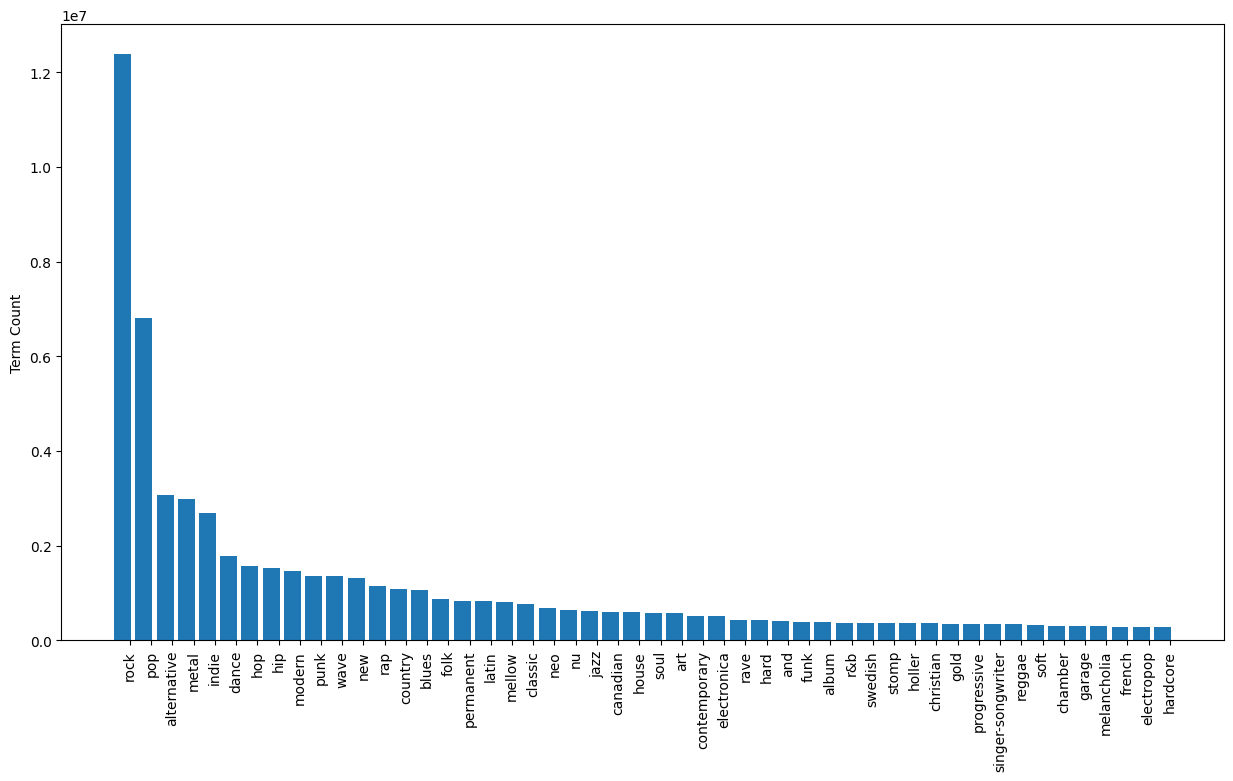

In [78]:
#plot histogram of genre words
counts = Counter(genre_words_split)

labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1] # sort your values in descending order

# rearrange data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35
  
fig = plt.figure(figsize = (15,8))
plt.bar(indexes[:50], values[:50]) #display top 50 terms

# add labels
plt.xticks(indexes[:50] + bar_width, labels[:50], rotation=90)
plt.ylabel('Term Count')
plt.show()

In [79]:
genre_words = msd_spot_df['artistGenres'].values
genre_words

array(['classic soul, funk, psychedelic soul, quiet storm, rock keyboard, soul, southern soul',
       'flamenco, flamenco guitar, rumba', 'alternative country', ...,
       'glam metal, hard rock, sleaze rock', 'christian hardcore',
       'tribute'], dtype=object)

In [80]:
#turn this into a list of individual words
genre_words_split = []
for entry in genre_words:
    if type(entry) == str:
        genre_words_split.append(entry.split(","))
        
genre_words_split = [word for elem in genre_words_split for word in elem] #flatten the list

In [82]:
genre_words_split = [word.strip() for word in genre_words_split]

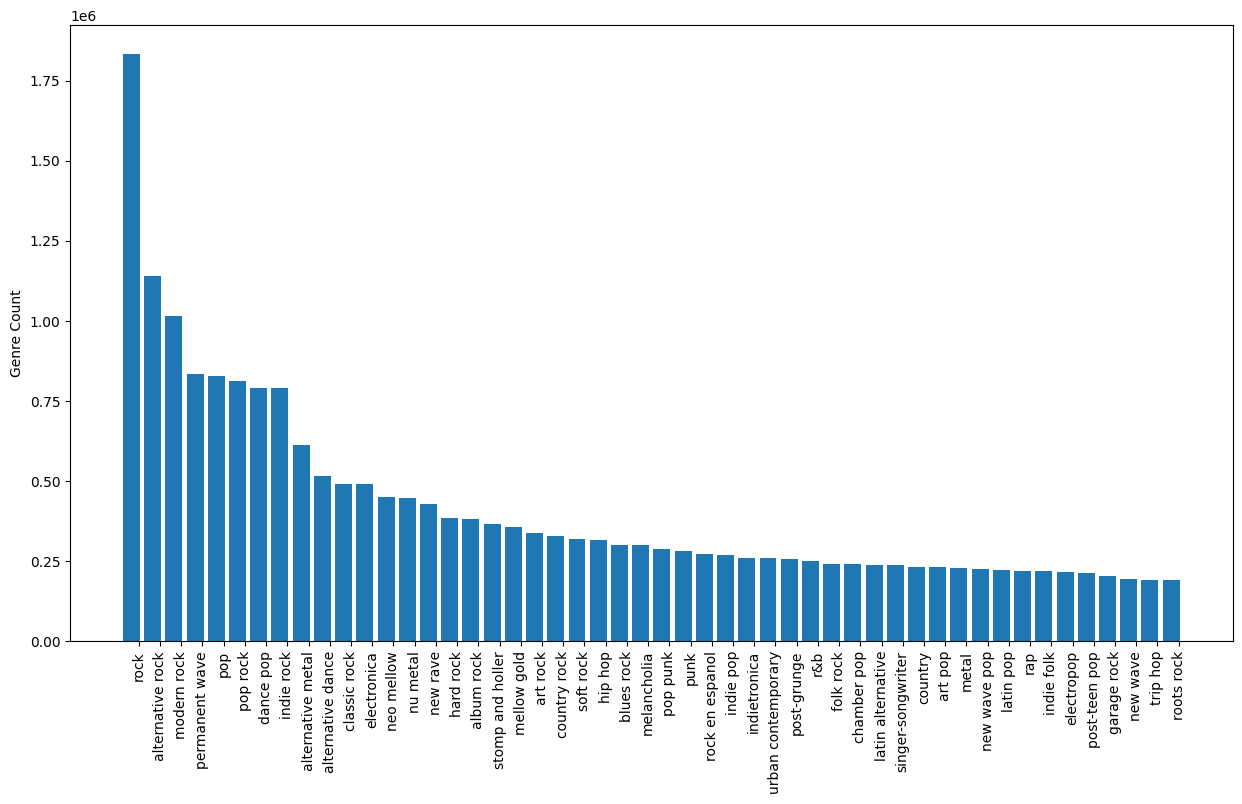

In [85]:
#plot histogram of genre words
counts = Counter(genre_words_split)

labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1] # sort your values in descending order

# rearrange data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35
  
fig = plt.figure(figsize = (15,8))
plt.bar(indexes[:50], values[:50]) #display top 50 terms

# add labels
plt.xticks(indexes[:50] + bar_width, labels[:50], rotation=90)
plt.ylabel('Genre Count')
plt.show()

Use the umbrella terms revealed in the plot plus genre names that are used in the MUSIC model paper as key terms. These are the terms we will try to identify and filter for in our data.

In [243]:
top_genres = labels[:50]

key_terms = [
    'rock',
    'alt',
    'pop',
    'metal',
    'indie',
    'hip hop',
    'dance',
    'punk',
    'rap',
    'country',
    'blues',
    'folk',
    'latin',
    'jazz',
    'house',
    'soul',
    'rave',
    'funk',
    'r&b',
    'singer',
    'reggae',
    'chamber',
    'hardcore',
    'new age', #added after seeing what was missing below
    'video game',
    'downtempo',
    'soundtrack',
    'trance',
    'dub',
    'tango',
    'rumba',
    'karaoke',
    'bluegrass',
    'lounge',
    'break',
    'ambient',
    'techno',
    'flamenco',
    'world',
    'industr',
    'electro',
    'nintendo',
    'neo mellow',
    'easy',
    'stomp',
    'celtic',
    'chill',
    'glitch',
    'jam',
    'lo-fi',
    'balkan',
    'melanch',
    'surf',
    'adult',
    'bossa nova',
    'tronica',
    'disco',
    'hardstyle',
    'salsa',
    'samba',
    'ska',
    'emo',
    'gospel',
    'vocaloid',
    'shojo',
    'grindcore',
    'hip-hop',
    'cappella',
    'big band',
    'hands up',
    'laboratorio',
    'psych',
    'bass',
    'grunge',
    'fiddle',
    'string',
    'banjo',
    'lullaby',
    'new wave',
    'dark wave',
    'children',
    'choir',
    'broadway',
    'classical',
    'folclore',
    'hollywood',
    'wonky',
    'trova'
]

### get data attributes

In both the Val-Aro-Dep and MUSIC models, those components were found by rating music from various genres accrording to descriptive sound-related (instrumental, loud, electric...) or psychological (intense, relaxing, sad...) attributes. We were able to get some similar types of attribute scores from the Spotify Web API, although these are not direct matches to what's in the literature. But let's try to select the attributes that are the closest matches and do some clustering based on that.

Let's look at the attributes: 

- trackAcoustic (sound related, could be the inverse analogue to the "electric" attribute in MUSIC paper)
- trackInstrum (sound related, instrumental is an attribute used in MUSIC paper)
- trackLoud (sound related, loud is an attribute used in MUSIC paper)
- trackTempo (sound related, fast is an attribute used in MUSIC paper)
- trackVal (psychological, sad is an attribute used in MUSIC and V-A-D paper)
- trackDanceable (psychological, danceable is an attribute used in V-A-D paper)

Note, we are excluding the energy metric for the time being. Spotify describes this as being related to many of the other acoustic features we already have on our list (we also saw this during the data exploration). So we will leave this one out for now due to the correlations.

In [244]:
msd_spot_clust_df = msd_spot_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']]
msd_spot_clust_df.head()

,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,0.61300,0.011200,-3.995,102.800,0.909,0.808
1,0.92300,0.874000,-12.673,102.814,0.924,0.461
2,0.02360,0.000008,-6.880,100.614,0.523,0.613
3,0.65100,0.001160,-9.239,78.005,0.507,0.749
4,0.00564,0.000000,-7.858,103.992,0.490,0.617


### plot the ranges of the attributes we are going to use

These data have various ranges, some are scaled to [0, 1] but others have units (like BPM or dB). Lets standardize everything.

In [245]:
msd_spot_clust_df = StandardScaler().fit_transform(msd_spot_clust_df)
msd_spot_clust_df = pd.DataFrame(msd_spot_clust_df, columns=['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable'])
msd_spot_clust_df.head()

,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,1.259146,-0.461198,1.046453,-0.672036,1.611714,1.512089
1,2.306686,2.580580,-1.070617,-0.671549,1.671528,-0.539553
2,-0.732530,-0.500657,0.342633,-0.748051,0.072495,0.359149
3,1.387554,-0.496594,-0.232864,-1.534250,0.008693,1.163251
4,-0.793220,-0.500684,0.104042,-0.630585,-0.059096,0.382799


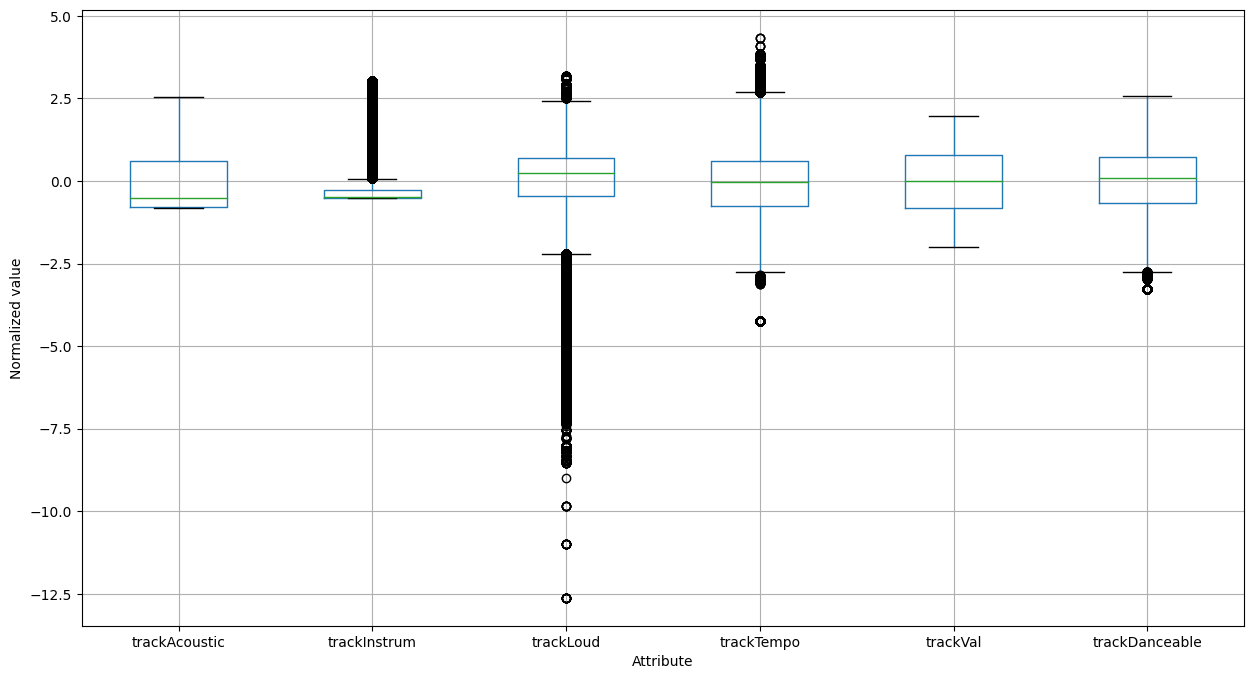

In [79]:
axs = msd_spot_clust_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']].boxplot(figsize=(15,8), return_type='axes')
axs.set_xlabel('Attribute')
axs.set_ylabel('Normalized value')

plt.show()

It looks like we have a lot of outliers in some of the attributes, which may cause us some issue with kmeans clustering.

Let's see how many outliers we have per attribute

In [90]:
#calculate interquartile range
q1 = msd_spot_clust_df.quantile(0.25)
q3 = msd_spot_clust_df.quantile(0.75)

for i,col in enumerate(msd_spot_clust_df.columns):
    print(i, col, ":", (~msd_spot_clust_df[col].between(q1[i]-1.5*(q3[i]-q1[i]), q3[i]+1.5*(q3[i]-q1[i]))).values.sum(), "outliers")

0 trackAcoustic : 0 outliers
1 trackInstrum : 2200270 outliers
2 trackLoud : 352721 outliers
3 trackTempo : 66581 outliers
4 trackVal : 0 outliers
5 trackDanceable : 14241 outliers


In [6]:
len(msd_spot_clust_df)

10633755

Let's just remove all the outlier points for simplicity, since we will still have a lot of data remaining. Except for the Instrumentalness outliers because there's a lot of those. Let's just leave those in for now and see what the data looks like

In [246]:
msd_spot_clust_df = msd_spot_clust_df.loc[(msd_spot_clust_df['trackLoud'].between(q1[2]-1.5*(q3[2]-q1[2]), q3[2]+1.5*(q3[2]-q1[2]))) & (msd_spot_clust_df['trackTempo'].between(q1[3]-1.5*(q3[3]-q1[3]), q3[3]+1.5*(q3[3]-q1[3]))) & (msd_spot_clust_df['trackDanceable'].between(q1[5]-1.5*(q3[5]-q1[5]), q3[5]+1.5*(q3[5]-q1[5]))),:]
msd_spot_clust_df.reset_index(inplace=True)

In [247]:
#msd_spot_clust_df.drop(columns=['index'], inplace=True)
msd_spot_clust_df

,index,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,0,1.259146,-0.461198,1.046453,-0.672036,1.611714,1.512089
1,1,2.306686,2.580580,-1.070617,-0.671549,1.671528,-0.539553
2,2,-0.732530,-0.500657,0.342633,-0.748051,0.072495,0.359149
3,3,1.387554,-0.496594,-0.232864,-1.534250,0.008693,1.163251
4,4,-0.793220,-0.500684,0.104042,-0.630585,-0.059096,0.382799
...,...,...,...,...,...,...,...
10210589,10633750,2.225586,-0.500663,-1.299694,-0.061061,-0.713064,0.187686
10210590,10633751,-0.810105,-0.500684,0.517551,-0.410050,0.116359,0.270461
10210591,10633752,-0.153342,-0.500684,0.876658,-1.060389,0.180161,-0.545466
10210592,10633753,-0.812260,-0.183743,0.935696,2.222217,1.077374,-2.064981


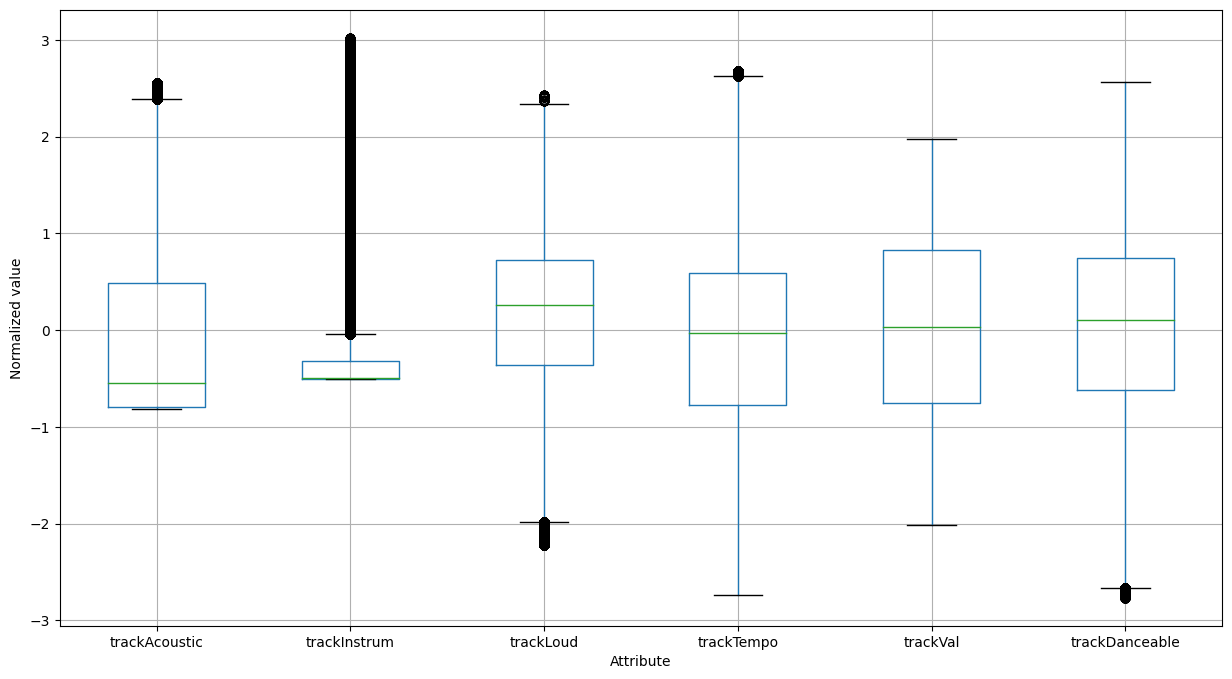

In [83]:
axs = msd_spot_clust_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']].boxplot(figsize=(15,8), return_type='axes')
axs.set_xlabel('Attribute')
axs.set_ylabel('Normalized value')

plt.show()

This looks better.... but Instrumentalness still appears to have a huge skew in the data, which may be a problem later. Let's visualize this:

<AxesSubplot: >

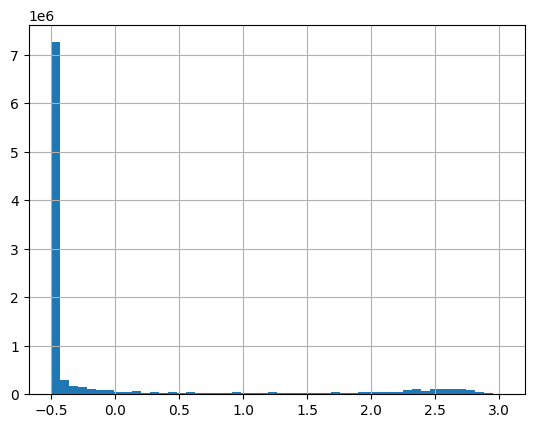

In [93]:
msd_spot_clust_df['trackInstrum'].hist(bins=50)

<AxesSubplot: >

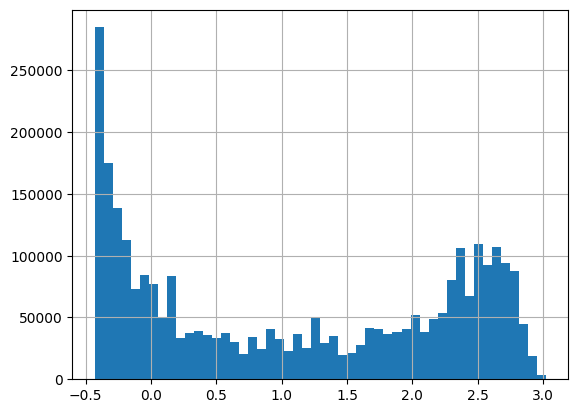

In [10]:
msd_spot_clust_df[msd_spot_clust_df['trackInstrum'] > -0.43]['trackInstrum'].hist(bins=50)

Let's resample this data so that Instrumentation is not so skewed, because this is a substantial skew.

Also 10 million data points is too many for my computer to attempt to handle (especially since SKLearn does not provide GPU support) so having fewer datapoints would be helpful.

In [11]:
counts, bins = np.histogram(msd_spot_clust_df['trackInstrum'], bins=50)
print("bins:", bins)
print("counts", counts)

bins: [-0.50068354 -0.43024458 -0.35980563 -0.28936668 -0.21892772 -0.14848877
 -0.07804981 -0.00761086  0.06282809  0.13326705  0.203706    0.27414495
  0.34458391  0.41502286  0.48546181  0.55590077  0.62633972  0.69677867
  0.76721763  0.83765658  0.90809553  0.97853449  1.04897344  1.1194124
  1.18985135  1.2602903   1.33072926  1.40116821  1.47160716  1.54204612
  1.61248507  1.68292402  1.75336298  1.82380193  1.89424088  1.96467984
  2.03511879  2.10555774  2.1759967   2.24643565  2.3168746   2.38731356
  2.45775251  2.52819147  2.59863042  2.66906937  2.73950833  2.80994728
  2.88038623  2.95082519  3.02126414]
counts [7257104  290712  177147  143276  108543   96960   80123   56353   56945
   75339   34634   39484   36231   44199   27931   40837   26051   26350
   29072   34727   38810   24964   32370   32813   43708   36325   26863
   34307   20257   27625   32653   46784   33339   31229   54515   48681
   38454   50438   51001   80760  108546   63953  107810  100979  102233
 

In [12]:
print(min(counts))

3800


Let's just make this a uniform distribution. So randomly sample 3800 points from each bin-- that will still give us 190k datapoints for clustering, which should be sufficient to find the centroids

In [248]:
np.random.seed(42)
sample_idx = np.array([])
for i in range(len(bins)-2):
    allrows = msd_spot_clust_df[(msd_spot_clust_df['trackInstrum'] < bins[i+1]) & (msd_spot_clust_df['trackInstrum'] >= bins[i])].index
    sample_idx = np.append(sample_idx, np.random.choice(allrows, size=3800, replace=False))
    
allrows = msd_spot_clust_df[(msd_spot_clust_df['trackInstrum'] <= bins[-1]) & (msd_spot_clust_df['trackInstrum'] >= bins[-2])].index
sample_idx = np.append(sample_idx, np.random.choice(allrows, size=3800, replace=False))

In [249]:
subsample_df = msd_spot_clust_df.iloc[sample_idx,:]
subsample_df.reset_index(inplace=True)

In [250]:
subsample_df.drop(columns=['level_0'], inplace=True)
subsample_df

C:\Users\sophi\AppData\Local\Temp\ipykernel_47492\2242265445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample_df.drop(columns=['level_0'], inplace=True)


,index,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,2952894,-0.551069,-0.500684,0.720769,-0.973872,0.371566,1.322888
1,3336131,-0.655147,-0.500684,0.674417,0.964868,-0.705089,-0.722841
2,2059374,0.606969,-0.500684,0.651728,-0.455465,1.500061,1.583039
3,1892984,-0.450708,-0.500684,0.219434,0.367143,0.016669,-0.261665
4,4167180,-0.254717,-0.500684,1.116713,-0.491108,-0.075046,0.849887
...,...,...,...,...,...,...,...
189995,5375334,1.411209,2.964857,-0.558061,-0.912009,-1.679662,-0.823354
189996,1639636,1.411209,2.964857,-0.558061,-0.912009,-1.679662,-0.823354
189997,3818617,-0.807615,3.000111,1.088902,0.087492,-0.130873,-0.397653
189998,5890405,-0.807615,3.000111,1.088902,0.087492,-0.130873,-0.397653


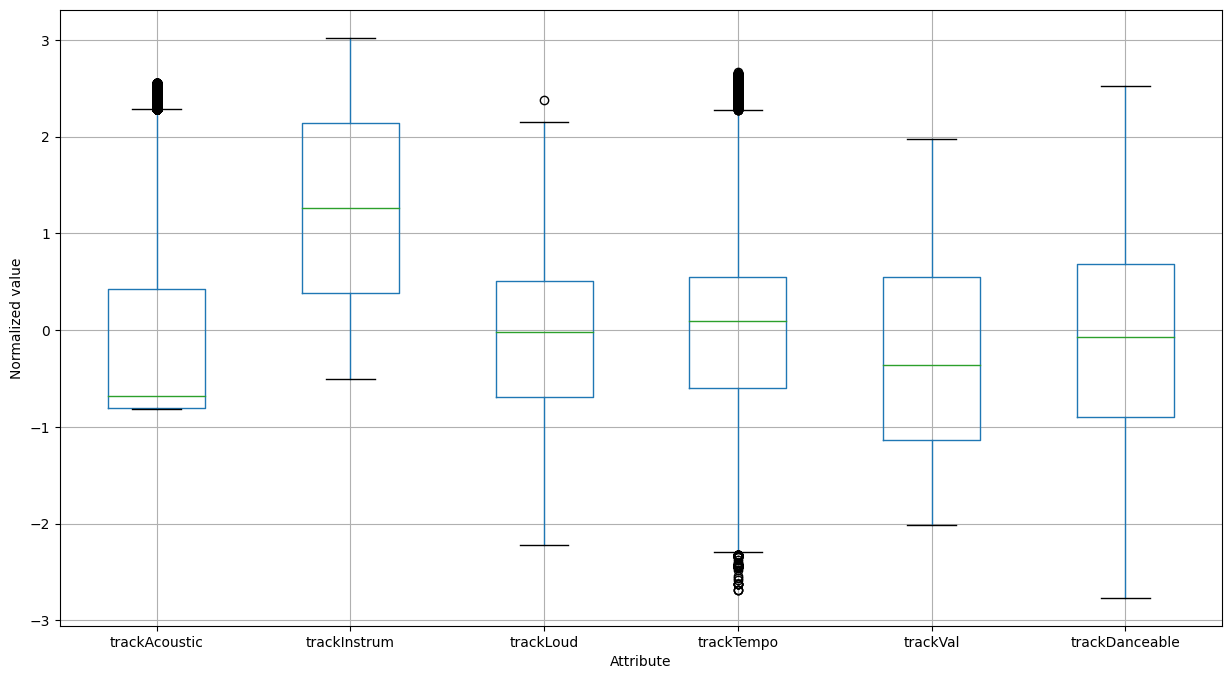

In [107]:
axs = subsample_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']].boxplot(figsize=(15,8), return_type='axes')
axs.set_xlabel('Attribute')
axs.set_ylabel('Normalized value')

plt.show()

### assign labels to data subsample

In [251]:
subsample_df['labels'] = ''
subsample_df.head()

C:\Users\sophi\AppData\Local\Temp\ipykernel_47492\2949142162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample_df['labels'] = ''


,index,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable,labels
0,2952894,-0.551069,-0.500684,0.720769,-0.973872,0.371566,1.322888,
1,3336131,-0.655147,-0.500684,0.674417,0.964868,-0.705089,-0.722841,
2,2059374,0.606969,-0.500684,0.651728,-0.455465,1.500061,1.583039,
3,1892984,-0.450708,-0.500684,0.219434,0.367143,0.016669,-0.261665,
4,4167180,-0.254717,-0.500684,1.116713,-0.491108,-0.075046,0.849887,


In [252]:
for i,row in subsample_df.iterrows():
    genres = msd_spot_df['artistGenres'][row['index']]
    lab = ''
    if type(genres) == str:
        for w in key_terms:
            if w in genres:
                lab = lab + '_' + w
        subsample_df.iloc[i,-1] = lab

In [253]:
subsample_df[subsample_df['labels']=='']

,index,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable,labels
20,5160712,0.309603,-0.500662,0.170643,-2.081937,-1.075937,-1.408692,
27,10329782,1.546375,-0.500684,-1.661972,2.026615,-0.258477,0.193599,
63,5196909,-0.176996,-0.498392,1.293095,0.878942,0.371566,-0.799704,
68,9113825,-0.460846,-0.500684,-0.381191,-0.735046,0.224025,0.577912,
79,8708998,0.880681,-0.500677,0.298477,-1.608840,-0.110935,-1.509205,
...,...,...,...,...,...,...,...,...
189989,5018216,-0.807615,3.000111,1.088902,0.087492,-0.130873,-0.397653,
189994,10413015,-0.807615,3.000111,1.088902,0.087492,-0.130873,-0.397653,
189997,3818617,-0.807615,3.000111,1.088902,0.087492,-0.130873,-0.397653,
189998,5890405,-0.807615,3.000111,1.088902,0.087492,-0.130873,-0.397653,


Lets visualize what the original genre labels were for these observations that are missing labels.

In [212]:
genre_words = msd_spot_df['artistGenres'][subsample_df[subsample_df['labels']=='']['index'].values].values

#turn this into a list of individual words
genre_words_split = []
for entry in genre_words:
    if type(entry) == str:
        genre_words_split.append(entry.split(","))
    else:
        genre_words_split.append(['nan'])
        
genre_words_split = [word for elem in genre_words_split for word in elem] #flatten the list

genre_words_split = [word.strip() for word in genre_words_split]

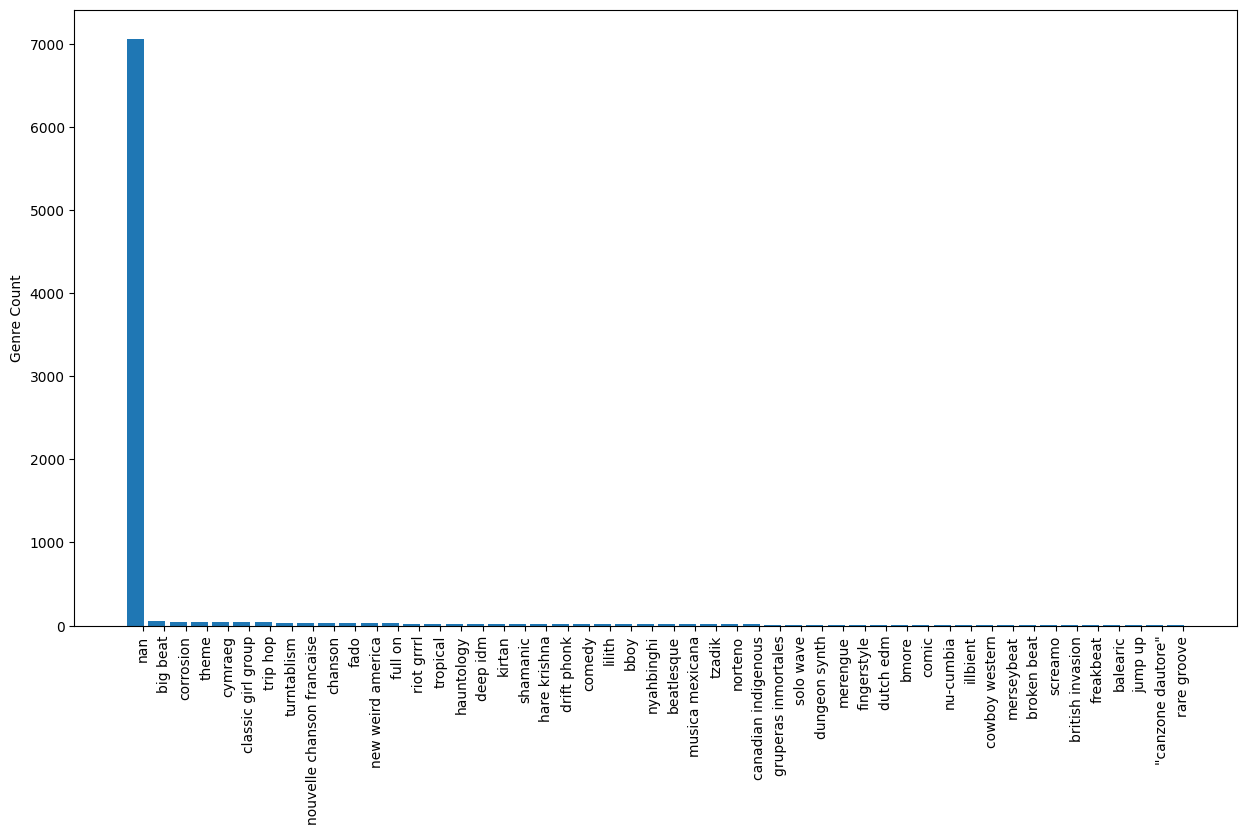

In [213]:
#plot histogram of genre words
counts = Counter(genre_words_split)

labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1] # sort your values in descending order

# rearrange data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35
  
fig = plt.figure(figsize = (15,8))
plt.bar(indexes[:50], values[:50]) #display top 50 terms

# add labels
plt.xticks(indexes[:50] + bar_width, labels[:50], rotation=90)
plt.ylabel('Genre Count')
plt.show()

Most of what is missing are NANs. Lets remove remaining missing rows

In [254]:
subsample_df = subsample_df[subsample_df['labels']!='']
subsample_df.reset_index(inplace=True)

In [255]:
subsample_df.drop(columns=['level_0','index'], inplace=True)

C:\Users\sophi\AppData\Local\Temp\ipykernel_47492\3709036341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample_df.drop(columns=['level_0','index'], inplace=True)


In [256]:
subsample_df['labels'] = subsample_df['labels'].str[1:]

C:\Users\sophi\AppData\Local\Temp\ipykernel_47492\198517666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample_df['labels'] = subsample_df['labels'].str[1:]


In [258]:
subsample_df = subsample_df.set_index('labels')

In [259]:
subsample_df.head()

,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
labels,,,,,,
alt_hip hop,-0.551069,-0.500684,0.720769,-0.973872,0.371566,1.322888
rock_alt_pop_metal_neo mellow_grunge,-0.655147,-0.500684,0.674417,0.964868,-0.705089,-0.722841
rock_pop_rumba_flamenco,0.606969,-0.500684,0.651728,-0.455465,1.500061,1.583039
rock_country,-0.450708,-0.500684,0.219434,0.367143,0.016669,-0.261665
alt_pop_dance_electro,-0.254717,-0.500684,1.116713,-0.491108,-0.075046,0.849887


### checkpoint: save sample of data

In [260]:
subsample_df.to_csv('clust_data_sample.csv')

### How many clusters are in our data?

### Elbow method:

(use this as an initial check/guide for optimal k)

computing k= 1
computing k= 2
computing k= 3
computing k= 4
computing k= 5
computing k= 6
computing k= 7
computing k= 8
computing k= 9
computing k= 10


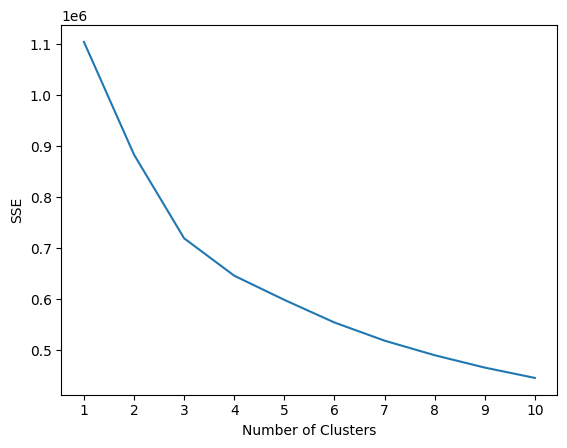

In [38]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 25,
"random_state": 42,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    print("computing k=",k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(subsample_df)
    sse.append(kmeans.inertia_)
    
#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhouette score:

computing k= 2
computing k= 3
computing k= 4
computing k= 5
computing k= 6
computing k= 7
computing k= 8
computing k= 9
computing k= 10


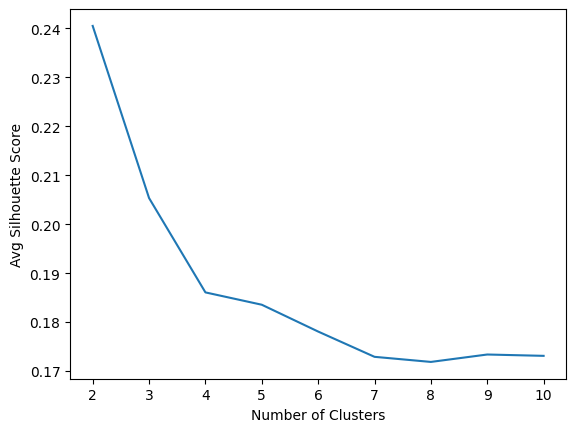

In [39]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 42,
}

sil_score = []
for k in range(2, 11):
    print("computing k=",k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(subsample_df)
    sil_score.append(silhouette_score(subsample_df, cluster_labels))
    
#visualize results
plt.plot(range(2, 11), sil_score)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Avg Silhouette Score")
plt.show()